v1

In [1]:
import sys
sys.path.append('../../')

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from modules import machine_learning_utils as mlu

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

# 1.0 Data retrieval

In [3]:
df = pd.read_pickle("../../data_lake/output/train_eng.pkl")
val = pd.read_pickle("../../data_lake/output/val_eng.pkl")

In [4]:
cols = ['card1', 'card2', 'card3','card5','M4', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_32', 'id_33', 'id_34',
       'id_35', 'id_36', 'id_37', 'id_38','num_transaction_per_time']

In [5]:
df = df.drop(columns=cols)

In [6]:
val = val.drop(columns=cols)

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
scaler = MinMaxScaler()

In [9]:
df = df[['isFraud','max_c','max_d','browser_enc','device_info_v4']]

In [10]:
df.dtypes

isFraud            object
max_c             float64
max_d             float64
browser_enc        object
device_info_v4     object
dtype: object

In [11]:
from scipy.stats import beta

In [12]:
for i in df:
    a = 9
    b = 1
    if df[i].dtypes == 'float64':
        df[i] = np.log1p(df[i])
        df[i] = scaler.fit_transform(df[i].values.reshape(-1,1))
        df[i] = beta.ppf(df[i], a, b)

In [13]:
df.sample(1)

,isFraud,max_c,max_d,browser_enc,device_info_v4
37803,0,0.0,0.0,chrome,other


<AxesSubplot:>

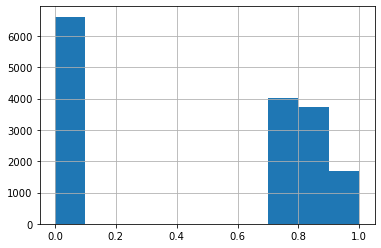

In [14]:
df['max_c'].hist()

<AxesSubplot:>

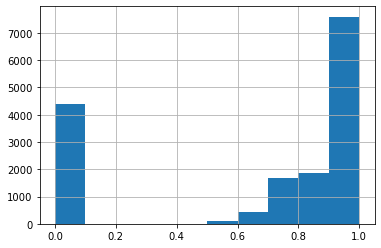

In [15]:
df['max_d'].hist()

In [16]:
df['warning_score'] = 0

In [17]:
w = [0.8,0.2]
df['warning_score'] = np.dot(df[['max_c','max_d']],w)

In [18]:
# df['warning_score'] = df['max_c'] + df['max_d']

<AxesSubplot:>

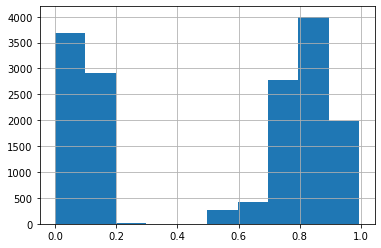

In [19]:
df['warning_score'].hist()

In [20]:
df['warning_score'] = df['warning_score'].mask(df['device_info_v4'] == 'other',df['warning_score']+0.05)
df['warning_score'] = df['warning_score'].mask(df['browser_enc'] == 'other',df['warning_score']+0.1)
df['warning_score'] = df['warning_score'].mask(df['warning_score']>=1,0.95)

<AxesSubplot:>

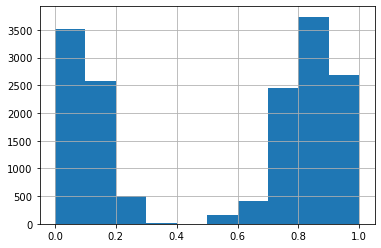

In [21]:
df['warning_score'].hist()

In [22]:
df.sample(3)

,isFraud,max_c,max_d,browser_enc,device_info_v4,warning_score
59940,0,0.000000,0.000000,other,other,0.150000
30403,1,0.976307,0.939563,ie,other,0.950000
29620,0,0.718535,0.867887,ie,windows,0.748406


In [27]:
df[(df['isFraud']==0) & (df['warning_score']<0.5)].shape

(4963, 6)

In [24]:
df['isFraud'].value_counts()

1    8027
0    8027
Name: isFraud, dtype: int64

# 2.0 Training baseline

In [7]:
for i in df:
    if df[i].dtypes == 'object':
        df[i] = df[i].astype(str)

In [8]:
X_train = df.drop(columns='isFraud')
y_train = df['isFraud'].astype(float)

In [9]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [10]:
parameters = {'model__max_depth':[6,8],'model__n_estimators':[500,800],'model__learning_rate':[0.05,0.1],'model__min_samples_leaf':[3,5]}

In [11]:
model = mlu.model_training(X_train,y_train,numerical_cols,categorical_cols,parameters)

GridSearchCV results...
Mean Train Scores: 
[0.87915758 0.89078492 0.8819401  0.90386593 0.92404796 0.92849121
 0.91881546 0.92288487 0.9127528  0.9127528  0.90262    0.90262
 0.94310833 0.94310833 0.92666503 0.92666503]

Mean CV Scores: 
[0.8275819  0.83032306 0.82558813 0.83480718 0.8340601  0.83480755
 0.83405985 0.8338106  0.83505655 0.83505655 0.83244046 0.83244046
 0.84128581 0.84128581 0.83667489 0.83667489]

Best Parameters: 
{'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__min_samples_leaf': 3, 'model__n_estimators': 500}



# 3.0 Evaluation baseline

In [12]:
for i in val:
    if val[i].dtypes == 'object':
        val[i] = val[i].astype(str)

In [13]:
X_val = val.drop(columns='isFraud')
y_val = val['isFraud'].astype(float)

In [14]:
m = mlu.model_calibration(model,X_val,y_val)

Test results...
Model Test Recall: 0.8517179023508138
--------------------------------------------------
Model Test Confusion Matrix
Classification report : 
               precision    recall  f1-score   support

         0.0       0.99      0.85      0.91     19976
         1.0       0.32      0.85      0.47      1659

    accuracy                           0.85     21635
   macro avg       0.65      0.85      0.69     21635
weighted avg       0.93      0.85      0.88     21635

ProductCD: 0.3204076362998419
TransactionAmt: 0.14343000107184956
card4: 0.13104672782140595
P_emaildomain: 0.025223769402368465
addr2: 0.012033488338027181
multi_transaction_per_time: 0.006267940261555033
R_emaildomain: 0.0051341140250081435
device_info_v4: 0.00510613494903186
DeviceType: 0.003658257210281853
max_d: 0.002309863815483917
max_c: 0.0014520695771733966
card6: 0.0010054128432358431
addr1: 3.549110105942713e-05
browser_enc: 2.5990696714438614e-05


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(add_indicator=True,
                                                                                    estimator=ExtraTreesRegressor(n_estimators=5,
                                                                                                                  random_state=1),
                                                                                    random_state=1)),
                                                                  ('scaler',
                                                                   FunctionTransformer(func=<function log_transform at 0x7fcac43359d0>))]),
                                                  Index(['TransactionAmt', 'max_c', 'max_d',...
                                 

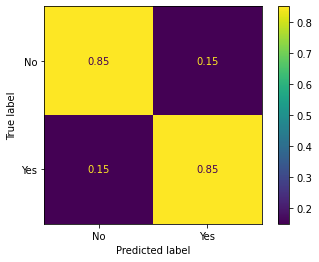

In [15]:
mlu.model_evaluation(m.base_estimator, X_val, y_val)

# 4.0 Predict probability

In [321]:
val = val.drop(columns='probability_score')

In [322]:
val.insert(0,'probability_score','')
val['probability_score'] = model.predict_proba(X_val)[:,1]

# 5.0 Sanity check

In [323]:
val['probability_score'] = val['probability_score'].mask((val['max_c'] > 1.0) & (val['max_d']<15),val['probability_score']+0.2)
val['probability_score'] = val['probability_score'].mask((val['max_c'] >= 5.0) & (val['max_d']<2),val['probability_score']+0.6)

In [324]:
val['probability_score'] = val['probability_score'].mask((val['max_c'] >= 10.0),val['probability_score']+0.3)
val['probability_score'] = val['probability_score'].mask((val['device_info_v4'] == 'other'),val['probability_score']+0.1)
val['probability_score'] = val['probability_score'].mask((val['browser_enc'] == 'other'),val['probability_score']+0.1)

In [325]:
val['probability_score'] = val['probability_score'].mask(val['probability_score'] >= 0.9,0.9)

# 6.0 Error analysis

In [326]:
val['probability_score'].max()

0.9

In [327]:
er2 = val[(val['probability_score']<0.5) & (val['isFraud']=='1')]

In [328]:
er2.shape

(198, 16)

In [329]:
er = val[(val['probability_score']>0.5) & (val['isFraud']=='0')]

In [330]:
er.shape

(4134, 16)

In [331]:
er2.sample(5)

,probability_score,isFraud,TransactionAmt,ProductCD,card4,card6,addr1,addr2,P_emaildomain,R_emaildomain,DeviceType,max_c,max_d,multi_transaction_per_time,browser_enc,device_info_v4
94066,0.476060,1,29.002,C,visa,credit,nan,nan,yahoo.es,yahoo.es,mobile,4.0,173.00,0,safari,other
64994,0.195948,1,50.000,H,visa,debit,315.0,87.0,gmail.com,gmail.com,desktop,1.0,398.75,0,firefox,windows
61351,0.265495,1,10.000,S,american express,credit,441.0,87.0,nan,gmail.com,desktop,1.0,0.00,0,chrome,windows
68540,0.153281,1,100.000,H,visa,debit,343.0,87.0,gmail.com,gmail.com,desktop,1.0,0.00,0,firefox,windows
54854,0.244260,1,20.755,C,visa,credit,nan,nan,hotmail.com,hotmail.com,mobile,1.0,0.00,0,safari,other


<AxesSubplot:>

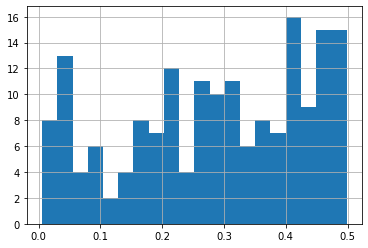

In [281]:
er2['probability_score'].hist(bins=20)

# 4.0 Model Output

In [15]:
with open('../../data_lake/output/trained_model_v1.pkl','wb') as file:
    pickle.dump(m.base_estimator, file)